# Porto Seguro's Safe Driver Prediction_using plotly
[참고] https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial <br>
[plotly] https://plot.ly/python/bar-charts/

### data info
* 유사한 feature들은 같은 태그를 가직고 있음 (ind, reg, car, calc,,,)
* bin이 붙어있는 컬럼은 binary features 이고, cat이 붙어있는 컬럼은 categorical features를 의미.
* 둘다 없는 features는 continuous 또는 ordinal 데이터
* -1 값은 missing data (nan 값이 -1로 처리되어있음)
* target컬럼은 보험계약자로부터의 청구 여부.

--------------------------------------------------------------------------------------------------------------------------------------------
### What I learned
* null값 유무 재확인
    * isnull().any().any()
* "missingno" package
    * visualising missing values in the dataset
* Counter 함수 : 데이터 타입 체크
* mutual_info_classif 함수 : x변수와 y변수간에 연관이 있는지를 확인하기 위함.
    * 숫자가 클수록 연관이 있는것
* plotly 에서 데이터는 list형태로 넣어줘야 함.
    * x,y값 모두 list형태
* seaborn 에서 scatter-plot 그리기
    * (+) x축 라벨 가로로 회전
* zip으로 묶은 값 (( A , B)) 에서 하나씩 값을 빼서 x = A , y = B로 할당
    * x,y=(list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse=False)))

In [196]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
init_notebook_mode(connected=True) 
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [193]:
import plotly
plotly.__version__

'3.3.0'

In [2]:
train = pd.read_csv("./train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [48]:
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {} rows and {} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


## 1. Data Quality checks

In [52]:
# any() applied twice to check run the isnull check across all columns.
train.isnull().any().any()

False

In [53]:
train_copy = train
train_copy= train_copy.replace(-1, np.NaN)    # -1 을 NaN으로 변경.

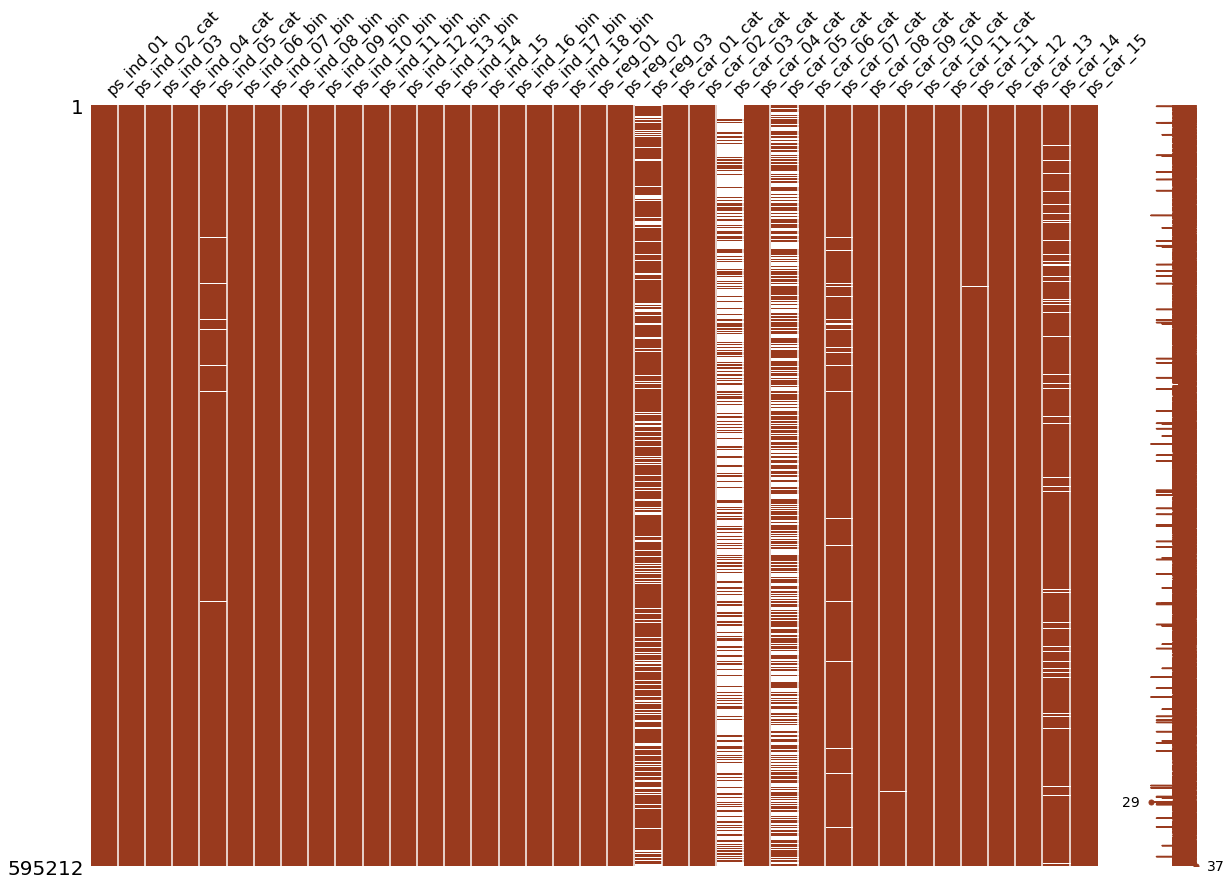

In [65]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20,14), color=(0.6,0.23,0.12))

null값이 있는 컬럼 :<br>
ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14 <br>
대다수의 null값이 '_cat' 이 포함된 컬럼임을 확인 <br>

그중에서도 ps_reg_03, ps_car_03_cat, ps_car_05_cat 이 세 컬럼이 null값이 많음.

In [71]:
train['target'].value_counts().values

array([573518,  21694])

In [199]:
#plotly.offline.init_notebook_mode(connected=True)
init_notebook_mode(connected=True) 
data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

### Datatype check
데이터 타입이 int 와 float 두가지로 나뉘는 것을 확인. 

In [72]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [97]:
# 데이터 타입이 float 인 데이터를 불러옴 
train_float = train.select_dtypes(include=['float64'])

# 데이터 타입이 int 인 데이터를 불러옴 
train_int = train.select_dtypes(include=['int64'])

### Correlation plots

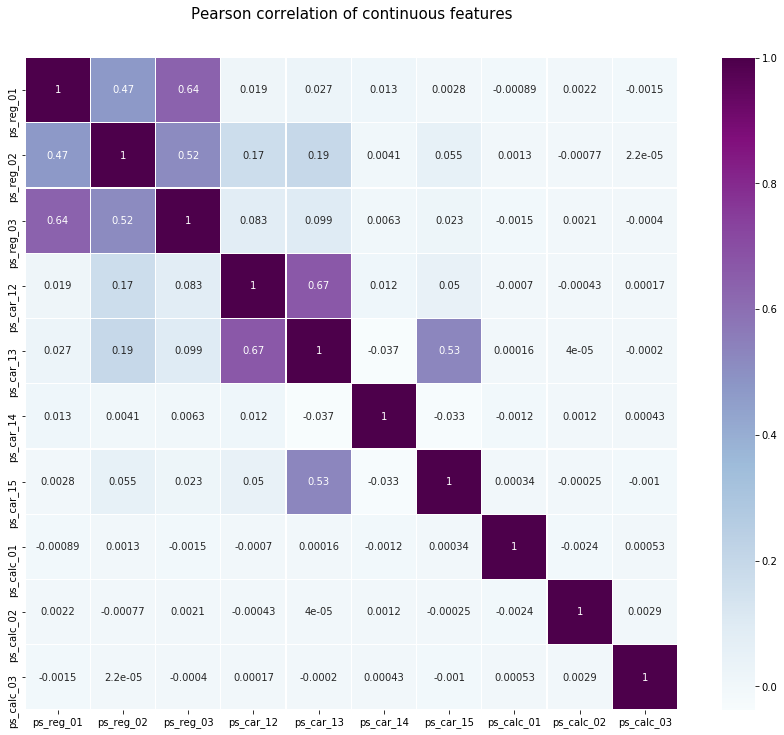

In [79]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True, cmap="BuPu", linecolor='white', annot=True)

양의 상관관계를 띄는 컬럼 조합 <br>
(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

### Correlation of integer features_(plotly)

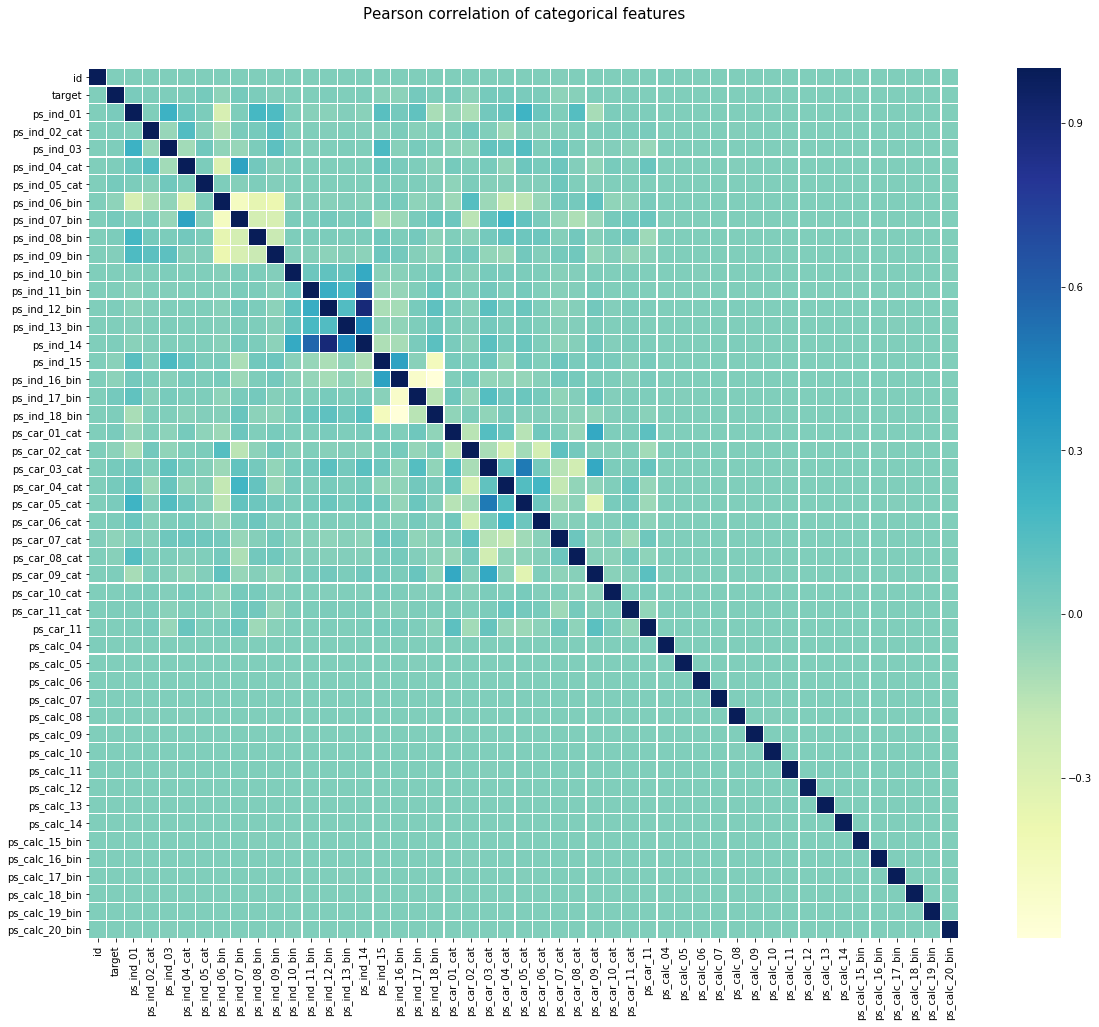

In [99]:
colormap = plt.cm.bone
plt.figure(figsize=(21,16))
plt.title('Pearson correlation of categorical features', y=1.05, size=15)
sns.heatmap(train_int.corr(),linewidths=0.1,vmax=1.0, square=True, cmap='YlGnBu', linecolor='white', annot=False)

음의 상관관계를 띄는 컬럼  <br>
ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

### Mutual Information plots
sklearn의 mutual_info_classif함수를 통해 상호 연관이 있는지에 대한 정보를 알 수 있다 . <br>
두 변수가 독립적이면 0에 가깝고, 의존적일수록 숫자가 크다.

In [106]:
# float형 변수들과 'target'변수 간에 연관이 있는지 확인.
mf = mutual_info_classif(train_float.values, train.target.values,n_neighbors=3, random_state=17 )
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


### Binary features inspection
0,1 값만 갖고 있는 컬럼들 분석. 모든 binary컬럼을 저장한 후 plotly로 시각화

In [152]:
# col 이라는 변수를 train.columns에서 꺼내서 저장하고, 만약 _bin 이 col 변수에 있으면 값 산출.
bin_col = [col for col in train.columns if '_bin' in col]
zero_list=[]
one_list=[]
for col in bin_col:
    # 값이 0인 row 합계
    zero_list.append((train[col]==0).sum())
    # 값이 1인 row 합계
    one_list.append((train[col]==1).sum())

In [200]:
trace1 = go.Bar(
x=bin_col,
y=zero_list,
name='Zero count')

trace2 = go.Bar(
x=bin_col,
y=one_list,
name='One count')

data=[trace1, trace2]

layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stack-bar')

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin 네개의 컬럼은 대부분 target 이 0 이다. <br>
이 컬럼들의 경우 target 1의 값이 거의 없기 때문에 유용하지 않을 것으로 판단됨.

### Categorical and Ordinal feature inspection
'_cat'이라고 끝나는 컬럼도 위와같은 방법으로 탐색

In [148]:
cat_col = [col for col in train.columns if '_cat' in col]
zero_list=[]
one_list=[]
for col in cat_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [201]:
trace1 = go.Bar(
x=cat_col,
y=zero_list,
name='Zero Count')

trace2 =go.Bar(
x=cat_col,
y=one_list,
name='One Count')

data = [trace1, trace2]

layout =go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in categorical variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stace-bar')

### Feature importance via Random Forest


In [156]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id','target'],axis=1), train.target)
features = train.drop(['id','target'], axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


### Scatter Plot of feature importances

In [ ]:
# Scatter plot with plotly
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

#### Seaborn scatter plot

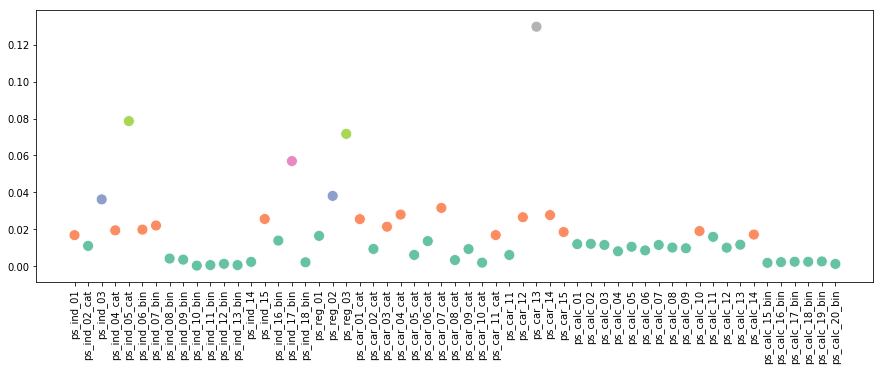

In [247]:
import seaborn as sns
plt.figure(figsize=(15,5))
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
g = sns.scatterplot(x=features, y=rf.feature_importances_, hue=rf.feature_importances_, palette="Set2", s=120, legend=False)
plt.xticks(features, rotation='vertical')
#g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

다음으로는, feature importance 순으로 가로막대그래프를 그려보자

In [267]:
# 컬럼별 중요도를 zip으로 묶은 값을 list로 반환 ---> ((0.12972589668605977, 'ps_car_13'),)
### x변수는 중요도 수치값 ---> 0.12972589668605977
### y변수는 컬럼명 ---> ps_car_13
x,y=(list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse=False)))

trace2 = go.Bar(
    x=x,
    y=y,
    marker = dict(
    color=x,
    colorscale='Viridis',
    reversescale=True
    ),
    name='Random Forest Feature importance',
    orientation='h'
)

layout=dict(
title ='Barplot of Feature importances',
width=900, height=2000,
yaxis=dict(
    showgrid=False,
        showline=False,
        showticklabels=True
))

fig1 = go.Figure(data=[trace2])
# 그래프 사이즈 커짐
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [271]:
list(zip(sorted(zip(rf.feature_importances_, features),reverse=True)))[0:5]

[((0.12972589668605977, 'ps_car_13'),),
 ((0.07861381065229754, 'ps_ind_05_cat'),),
 ((0.07169756523163816, 'ps_reg_03'),),
 ((0.056972129046208644, 'ps_ind_17_bin'),),
 ((0.038131333126062074, 'ps_reg_02'),)]

### Decision Tree visualisation